In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
path_dataset = '../dataset/'
dir_data = path_dataset + 'images'
dir_gt = path_dataset + 'groundtruth'
dir_mask = '../new datasets/masks_DL'

In [3]:
# Get the paths of every file given a parent directory
def get_all_files(path):
    vect = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if (name == '.DS_Store') | (name=='Readme.txt'):
                pass
            else:
                vect.append(os.path.join(path, name))
        vect = sorted(vect)
    return vect

In [4]:
labels = []
for i in range(0,224):
    for j in range(0,10):
        labels.append(i)
labels = np.array(labels)
print((labels[10:20]))
print(len(labels))
mask_ls = get_all_files(dir_mask)
masks = np.zeros((2240,240,320,1), dtype = np.bool)

[1 1 1 1 1 1 1 1 1 1]
2240


In [5]:
# Get the masks
n = 0
for i in mask_ls:
  im = np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), axis = -1)
  #im = (im-np.min(im))/(np.max(im)-np.min(im))
  masks[n] = im
  n += 1

(2240, 240, 320, 1)
[False, True]


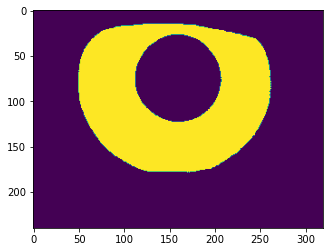

In [9]:
print(masks.shape)
im_test = np.squeeze(masks[50,:,:,:])
plt.imshow(im_test)
print([np.min(im_test), np.max(im_test)])

In [7]:
# Get the data 
images = get_all_files(dir_data)
data = np.zeros((2240,240,320,1))
n=0 
for i in images:
    im = np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), axis = -1)
    im = (im-np.min(im))/(np.max(im)-np.min(im))
    data[n]= im
    n+=1

(2240, 240, 320, 1)
[0.0, 1.0]


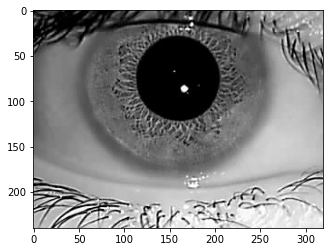

In [8]:
print(data.shape)
data_test = np.squeeze(data[50,:,:,0])
plt.imshow(data_test, cmap='gray')
print([np.min(data_test), np.max(data_test)])

In [10]:
# Save data 
import pickle 

pickle_out = open("iris_data", 'wb')
pickle.dump(data, pickle_out)           
pickle_out.close()

pickle_out = open("iris_masks_dl", 'wb')
pickle.dump(masks, pickle_out)           
pickle_out.close()

pickle_out = open("labels", "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [11]:
#import data : 
import pickle
import numpy as np

data = np.load("iris_data", allow_pickle = True)
masks = np.load("iris_masks_dl", allow_pickle = True)
labels = np.load("labels", allow_pickle = True)

In [12]:
feat = np.load("DL_recognition_features", allow_pickle = True)
feat.shape

(2240, 2240)

In [13]:
import random
# Spliting 
x_im_train = np.zeros((1120,240,320,1))
x_mask_train = np.zeros((1120,240,320,1), dtype = np.bool)

x_im_test = np.zeros((1120,240,320,1))
x_mask_test = np.zeros((1120,240,320,1), dtype = np.bool)

labels_train = np.zeros((1120,1), dtype=np.uint16)
labels_test = np.zeros((1120,1), dtype=np.uint16) 


x_im_train = []
x_im_test = []
x_mask_train = []
x_mask_test = []
labels_train = []
labels_test = []
indexes_to_test = []
random.seed(0)
for i in range(0,224):
    train = random.sample(range(0, 10), 5)
    for k in train:
        indexes_to_test.append(i*10+k)    
print(indexes_to_test[:20])  
n_of_subjects = len(labels)
for i in range(0,n_of_subjects):
    if i in indexes_to_test:
        x_im_train.append(data[i,:,:,:])
        x_mask_train.append(masks[i,:,:,:])
        labels_train.append(labels[i])
    else:
        x_im_test.append(data[i,:,:,:])
        x_mask_test.append(masks[i,:,:,:])
        labels_test.append(labels[i])
x_im_train = np.array(x_im_train)
x_im_test = np.array(x_im_test)
x_mask_train = np.array(x_mask_train)
x_mask_test = np.array(x_mask_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

[6, 9, 0, 2, 4, 17, 16, 14, 13, 12, 29, 23, 22, 27, 21, 31, 34, 32, 37, 30]


In [15]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
def double_conv(inputs,
    use_batch_norm=False,
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    do=0.0):
    c = Conv2D(
        filters,
        (3,3),
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if do>0:
        c = Dropout(do)(c)
    c = Conv2D(
        filters,
        (3,3),
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    return c     

def final_model_def(filters=8,do=0.0):
    x = Input(shape=(240,320,1))
    mask = Input(shape=(240,320,1))
    x1 = x*mask
    x2 = double_conv(x1,filters=filters,do=do)
    x2 = MaxPooling2D((2, 2))(x2)
    x3 = double_conv(x2, filters=filters*2,do=do)
    x3 = MaxPooling2D((2, 2))(x3)
    x4 = double_conv(x3, filters=filters*4,do=do)
    x4 = MaxPooling2D((2, 2))(x4)
    x5 = double_conv(x4, filters=filters*8,do=do)
    x5 = MaxPooling2D((2, 2))(x5)
    x6 = double_conv(x5, filters=filters*16,do=do)

    flat = MaxPooling2D(2)(x6)
    flat = Flatten()(flat)
    flat = Dense(1024)(flat)
    flat = Dense(512)(flat)
    out = Dense(224,activation=tf.keras.activations.softmax)(flat)

    model = Model(inputs=[x,mask], outputs=[out])

    return model

In [18]:
from keras_unet.models import custom_unet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
final_model = final_model_def(filters=2,do=0.0)
lr = 1e-3
epochs = 30
LF = "categorical_crossentropy"
# Create optimizer, metrics and compile the model
opt = tf.keras.optimizers.Adam(lr)
final_model.compile(optimizer=opt, loss=LF, metrics=["accuracy"])


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [19]:
# Adjust the masks with the delta value
x_mask_train_delta = x_mask_train*1.0
x_mask_test_delta = x_mask_test*1.0
delta = 0.6
x_mask_train_delta[x_mask_train_delta==0.0] = delta
x_mask_test_delta[x_mask_test_delta==0.0] = delta

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, verbose=1, min_lr=1e-7),
]
history = final_model.fit([x_im_train,x_mask_train_delta], to_categorical(labels_train),
        batch_size = 64,
        epochs=epochs,
        validation_data= ([x_im_test,x_mask_test_delta],to_categorical(labels_test)),
        callbacks=callbacks
    )

Epoch 1/30
18/18 [==============================] - 5s 233ms/step - loss: 5.5226 - accuracy: 0.0121 - val_loss: 5.3428 - val_accuracy: 0.0286
Epoch 2/30
18/18 [==============================] - 3s 166ms/step - loss: 5.1952 - accuracy: 0.0377 - val_loss: 3.9560 - val_accuracy: 0.1696
Epoch 3/30
18/18 [==============================] - 3s 166ms/step - loss: 3.0699 - accuracy: 0.3192 - val_loss: 2.7114 - val_accuracy: 0.4223
Epoch 4/30
18/18 [==============================] - 3s 169ms/step - loss: 1.3554 - accuracy: 0.6824 - val_loss: 1.3930 - val_accuracy: 0.7321
Epoch 5/30
18/18 [==============================] - 3s 164ms/step - loss: 0.3843 - accuracy: 0.9083 - val_loss: 1.1313 - val_accuracy: 0.8143
Epoch 6/30
18/18 [==============================] - 3s 164ms/step - loss: 0.1119 - accuracy: 0.9631 - val_loss: 1.0831 - val_accuracy: 0.8313
Epoch 7/30
18/18 [==============================] - 3s 162ms/step - loss: 0.0608 - accuracy: 0.9833 - val_loss: 1.1624 - val_accuracy: 0.8402
Epoch 

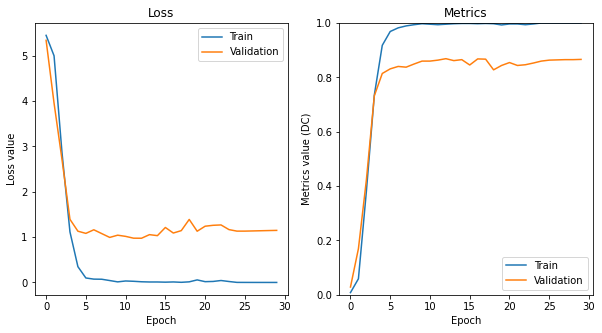

In [20]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.title.set_text('Loss')
ax1.set_ylabel('Loss value')
ax1.set_xlabel('Epoch')
ax1.legend(['Train','Validation'], loc='upper right')
#summarize history for metrics
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylim([0, 1])
ax2.title.set_text('Metrics')
ax2.set_ylabel('Metrics value (DC)')
ax2.set_xlabel('Epoch')
ax2.legend(['Train','Validation'], loc='lower right')

In [21]:
final_model.evaluate([x_im_test, x_mask_test_delta],to_categorical(labels_test), batch_size=64, verbose=1)

18/18 [==============================] - 1s 51ms/step - loss: 1.1491 - accuracy: 0.8661


[1.1491355895996094, 0.8660714030265808]

In [ ]:
# Extracting the flattened features after the encoder for ML recognition
XX = final_model.input 
YY = final_model.layers[18].output
new_model = Model(XX, YY)

results = new_model.predict([data, masks])
print(results.shape)

pickle_out = open("DL_recognition_features", 'wb')
pickle.dump(results, pickle_out)           
pickle_out.close()

In [22]:
# ROC and AUC
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
y_score = to_categorical(labels_test)
pred = final_model.predict([x_im_test,x_mask_test_delta])
y_test = pred
n_classes = 224

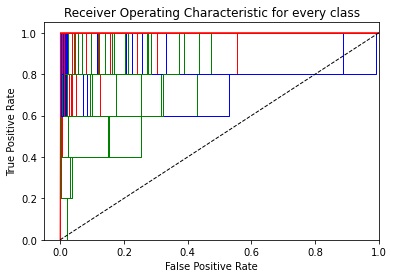

In [23]:
# Binary classification ROC
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_score[:, i], y_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for every class')
#plt.legend(loc="lower right")
plt.show()

<ipython-input-24-66eb8cef2e30>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


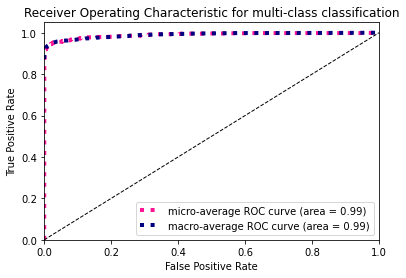

In [24]:
# Multi-class classification ROC
from scipy import interp
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_score.ravel(), y_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class classification')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Equal Error Rate calculation
fpr, tpr, threshold = roc_curve(y_score.ravel(), y_test.ravel())
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print([EER1, EER2])

[0.04025064061499039, 0.043749999999999956]


In [26]:
# Decidability index calculation
d_vect = []
for i in range(0,223):
    mg = np.mean(pred[5*i:5*(i+1),:])
    mi = np.mean(pred[5*(i+1)::,:])
    mug = np.std(pred[5*i:5*(i+1),:])
    mui = np.std(pred[5*(i+1)::,:])
    d = np.abs(mg-mi)/(np.sqrt((np.power(mug,2)+np.power(mui,2))/2))
    d_vect.append(d)
print(np.mean(d_vect))

0.0
1.6806735157447399e-09


<AxesSubplot:>

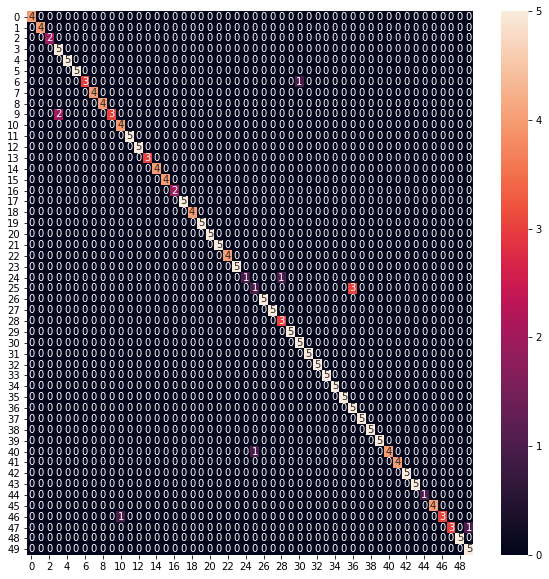

In [27]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
pred = final_model.predict([x_im_test,x_mask_test_delta])
cm = confusion_matrix(labels_test,np.argmax(pred,axis=1))
init = 100
end = 150
df_cm = pd.DataFrame(cm[init:end,init:end])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)